# Data preprocessing

This notebook is used to create the datasets used for training the models.

From the original datasets different splits are created:
- AP/PA: Only AP and PA images are used
- Lateral: Only lateral images are used
- Frontal: Only frontal images are used
- All data: All images are used

In addition, three families of datasets are created using these splits.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import os
from pathlib import Path
from sklearn.model_selection import train_test_split


# Splitted Dataset

This family of dataset creates a new 90/5/5 split using different parts of the original dataset.

In [ ]:
# Load data
cwd_path = Path.cwd()
metadata_path = cwd_path.parent.joinpath("../image_data/CheXpert-v1.0-small/train.csv")
val_path = cwd_path.parent.joinpath("../image_data/CheXpert-v1.0-small/valid.csv")
test_path = cwd_path.parent.joinpath("data/original_data/test.csv")
train_og = pd.read_csv(metadata_path)
print(f"Len train: {len(train_og)}")
val_og = pd.read_csv(val_path)
print(f"Len val: {len(val_og)}")
test_og = pd.read_csv(test_path)
print(f"Len test: {len(test_og)}")
metadata = pd.concat([train_og, val_og, test_og])
print(f"Len metadata: {len(metadata)}")

# Removing the single 'Unknown' value in 'Sex' 
metadata = metadata[metadata['Sex'] != 'Unknown']

Len train: 223414
Len val: 234
Len test: 668
Len metadata: 224316


In [ ]:
# Define the columns to map NaN values to -1.0
columns_to_map = [
    "No Finding", "Enlarged Cardiomediastinum", "Cardiomegaly", 
    "Lung Opacity", "Lung Lesion", "Edema", "Consolidation", 
    "Pneumonia", "Atelectasis", "Pneumothorax", "Pleural Effusion", 
    "Pleural Other", "Fracture", "Support Devices"
]

# Use .loc[] to modify the original DataFrame
metadata.loc[:, columns_to_map] = metadata[columns_to_map].fillna(-1.0)

metadata['Sex_mapped'] = pd.factorize(metadata['Sex'])[0]
metadata['Frontal/Lateral_mapped'] = pd.factorize(metadata['Frontal/Lateral'])[0]
metadata['AP/PA_mapped'] = pd.factorize(metadata['AP/PA'])[0]

In [6]:
metadata.isna().sum()

# AP/PA is NULL when Frontal/Lateral is Lateral

Path                              0
Sex                             668
Age                             668
Frontal/Lateral                   0
AP/PA                         33087
No Finding                        0
Enlarged Cardiomediastinum        0
Cardiomegaly                      0
Lung Opacity                      0
Lung Lesion                       0
Edema                             0
Consolidation                     0
Pneumonia                         0
Atelectasis                       0
Pneumothorax                      0
Pleural Effusion                  0
Pleural Other                     0
Fracture                          0
Support Devices                   0
Sex_mapped                        0
Frontal/Lateral_mapped            0
AP/PA_mapped                      0
dtype: int64

In [7]:
# Step 1: Perform a 95/5 Train-Val Split
train_df, valid_df = train_test_split(
    metadata, 
    test_size=0.1, 
    random_state=42, 
    shuffle=True)

# Step 2: Perfrom a 50/50 Val-Test Split
valid_df, test_df = train_test_split(
    valid_df, 
    test_size=0.5, 
    random_state=42, 
    shuffle=True)


In [8]:
# Get number of 0, 1 and -1 in each column
def get_class_distribution(metadata):
    class_distribution = {}
    for column in columns_to_map:
        class_distribution[column] = metadata[column].value_counts()
    return class_distribution

train_class_distribution = get_class_distribution(train_df)
valid_class_distribution = get_class_distribution(valid_df)
test_class_distribution = get_class_distribution(test_df)

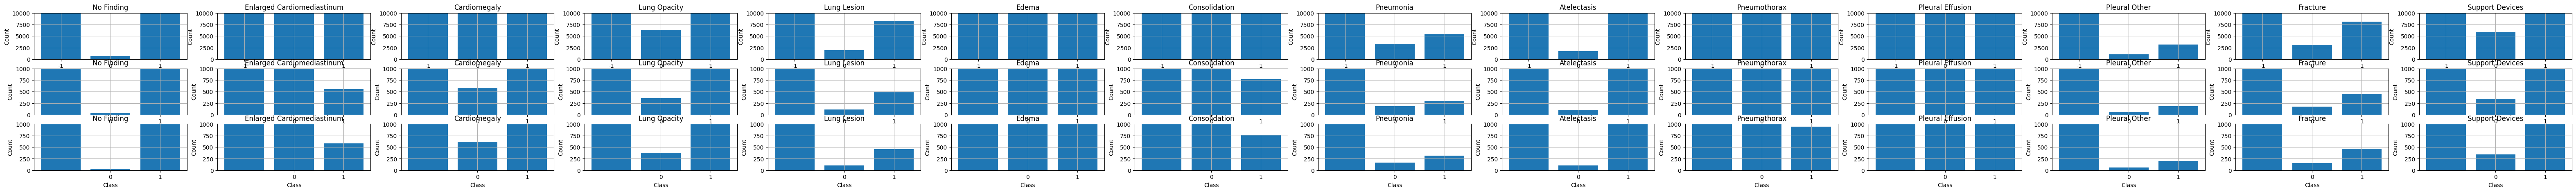

In [9]:
# Plot the class distribution
fig, ax = plt.subplots(3, len(train_class_distribution), figsize=(80, 5))
for i, (key, value) in enumerate(train_class_distribution.items()):
    ax[0, i].bar(value.index, value.values)
    ax[0, i].set_title(key)
    ax[0, i].set_xlabel("Class")
    ax[0, i].set_ylabel("Count")
    ax[0, i].set_xticks([-1, 0, 1])
    ax[0, i].set_xticklabels(["-1", "0", "1"])
    ax[0, i].set_ylim(0, 10000)
    ax[0, i].grid()

for i, (key, value) in enumerate(valid_class_distribution.items()):
    ax[1, i].bar(value.index, value.values)
    ax[1, i].set_title(key)
    ax[1, i].set_xlabel("Class")
    ax[1, i].set_ylabel("Count")
    ax[1, i].set_xticks([0, 1])
    ax[1, i].set_xticklabels(["0", "1"])
    ax[1, i].set_ylim(0, 1000)
    ax[1, i].grid()

for i, (key, value) in enumerate(test_class_distribution.items()):
    ax[2, i].bar(value.index, value.values)
    ax[2, i].set_title(key)
    ax[2, i].set_xlabel("Class")
    ax[2, i].set_ylabel("Count")
    ax[2, i].set_xticks([0, 1])
    ax[2, i].set_xticklabels(["0", "1"])
    ax[2, i].set_ylim(0, 1000)
    ax[2, i].grid()

In [10]:
## Split and create .csv for the training of the segments 

train_df_ap = train_df[train_df['AP/PA'] == 'AP']
train_df_pa = train_df[train_df['AP/PA'] == 'PA']
valid_df_ap = valid_df[valid_df['AP/PA'] == 'AP']
valid_df_pa = valid_df[valid_df['AP/PA'] == 'PA']
test_df_ap = test_df[test_df['AP/PA'] == 'AP']
test_df_pa = test_df[test_df['AP/PA'] == 'PA']
train_df_fr = train_df[train_df['Frontal/Lateral'] == 'Frontal']
train_df_lat = train_df[train_df['Frontal/Lateral'] == 'Lateral']
valid_df_fr = valid_df[valid_df['Frontal/Lateral'] == 'Frontal']
valid_df_lat = valid_df[valid_df['Frontal/Lateral'] == 'Lateral']
test_df_fr = test_df[test_df['Frontal/Lateral'] == 'Frontal']
test_df_lat = test_df[test_df['Frontal/Lateral'] == 'Lateral']

In [11]:
train_class_distribution_ap = get_class_distribution(train_df_ap)
valid_class_distribution_ap = get_class_distribution(valid_df_ap)
test_class_distribution_ap = get_class_distribution(test_df_ap)
train_class_distribution_pa = get_class_distribution(train_df_pa)
valid_class_distribution_pa = get_class_distribution(valid_df_pa)
test_class_distribution_pa = get_class_distribution(test_df_pa)
train_class_distribution_fr = get_class_distribution(train_df_fr)
valid_class_distribution_fr = get_class_distribution(valid_df_fr)
test_class_distribution_fr = get_class_distribution(test_df_fr)
train_class_distribution_lat = get_class_distribution(train_df_lat)
valid_class_distribution_lat = get_class_distribution(valid_df_lat)
test_class_distribution_lat = get_class_distribution(test_df_lat)

# Print the number of samples in each split
print("All")
print(f"Train: {len(train_df)}")
print(f"Valid: {len(valid_df)}")
print(f"Test: {len(test_df)}")

print("AP")
print(f"Train AP: {len(train_df_ap)}")
print(f"Valid AP: {len(valid_df_ap)}")
print(f"Test AP: {len(test_df_ap)}")

print("PA")
print(f"Train PA: {len(train_df_pa)}")
print(f"Valid PA: {len(valid_df_pa)}")
print(f"Test PA: {len(test_df_pa)}")

print("Frontal")
print(f"Train Frontal: {len(train_df_fr)}")
print(f"Valid Frontal: {len(valid_df_fr)}")
print(f"Test Frontal: {len(test_df_fr)}")

print("Lateral")
print(f"Train Lateral: {len(train_df_lat)}")
print(f"Valid Lateral: {len(valid_df_lat)}")
print(f"Test Lateral: {len(test_df_lat)}")


All
Train: 201883
Valid: 11216
Test: 11216
AP
Train AP: 145545
Valid AP: 8104
Test AP: 8110
PA
Train PA: 26535
Valid PA: 1439
Test PA: 1478
Frontal
Train Frontal: 172558
Valid Frontal: 9570
Test Frontal: 9618
Lateral
Train Lateral: 29325
Valid Lateral: 1646
Test Lateral: 1598


In [12]:
# Define the path 
output_dir = os.path.join(cwd_path.parent, 'data', 'new_90_5_5')

# Create the directory
os.makedirs(output_dir, exist_ok=True)

# Save these subsets to CSVs
train_df.to_csv(os.path.join(output_dir, 'train.csv'), index=False)
valid_df.to_csv(os.path.join(output_dir, 'valid.csv'), index=False)
test_df.to_csv(os.path.join(output_dir, 'test.csv'), index=False)
train_df_ap.to_csv(os.path.join(output_dir, 'ap_train.csv'), index=False)
train_df_pa.to_csv(os.path.join(output_dir, 'pa_train.csv'), index=False)
valid_df_ap.to_csv(os.path.join(output_dir, 'ap_valid.csv'), index=False)
valid_df_pa.to_csv(os.path.join(output_dir, 'pa_valid.csv'), index=False)
test_df_ap.to_csv(os.path.join(output_dir, 'ap_test.csv'), index=False)
test_df_ap.to_csv(os.path.join(output_dir, 'ap_test.csv'), index=False)
train_df_fr.to_csv(os.path.join(output_dir, 'fr_train.csv'), index=False)
train_df_lat.to_csv(os.path.join(output_dir, 'lat_train.csv'), index=False)
valid_df_fr.to_csv(os.path.join(output_dir, 'fr_valid.csv'), index=False)
valid_df_lat.to_csv(os.path.join(output_dir, 'lat_valid.csv'), index=False)
test_df_ap.to_csv(os.path.join(output_dir, 'ap_test.csv'), index=False)
test_df_ap.to_csv(os.path.join(output_dir, 'ap_test.csv'), index=False)


print("Datasets have been saved.")

Datasets have been saved.


In [13]:
print(output_dir)

c:\Users\rugge\cascade_learning\Personalized_ML\data\new_90_5_5


# Dataset Valid Only

This dataset is created using the validation set of the original dataset as test set. From the original training set, the new test set is extracted using all samples that have no uncertainty labels for the five classes "Cardiomegaly", "Atelectasis", "Pleural Effusion", "Pneumothorax" and "Consolidation".

In [18]:
cwd_path = Path.cwd()
metadata_path = cwd_path.parent.joinpath("../image_data/CheXpert-v1.0-small/train.csv")
val_path = cwd_path.parent.joinpath("../image_data/CheXpert-v1.0-small/valid.csv")
train_og = pd.read_csv(metadata_path)
print(f"Len train: {len(train_og)}")
val_og = pd.read_csv(val_path)
print(f"Len val: {len(val_og)}")
metadata = pd.concat([train_og, val_og])
print(f"Len metadata: {len(metadata)}")

# Removing the single 'Unknown' value in 'Sex' 
metadata = metadata[metadata['Sex'] != 'Unknown']

Len train: 223414
Len val: 234
Len metadata: 223648


In [19]:
# Define the columns to map NaN values to -1.0
columns_to_map = [
    "No Finding", "Enlarged Cardiomediastinum", "Cardiomegaly", 
    "Lung Opacity", "Lung Lesion", "Edema", "Consolidation", 
    "Pneumonia", "Atelectasis", "Pneumothorax", "Pleural Effusion", 
    "Pleural Other", "Fracture", "Support Devices"
]

# Use .loc[] to modify the original DataFrame
metadata.loc[:, columns_to_map] = metadata[columns_to_map].fillna(-1.0)

# Use .loc[] to modify the original DataFrame
train_og.loc[:, columns_to_map] = train_og[columns_to_map].fillna(-1.0)

# Use .loc[] to modify the original DataFrame
val_og.loc[:, columns_to_map] = val_og[columns_to_map].fillna(-1.0)

metadata['Sex_mapped'] = pd.factorize(metadata['Sex'])[0]
metadata['Frontal/Lateral_mapped'] = pd.factorize(metadata['Frontal/Lateral'])[0]
metadata['AP/PA_mapped'] = pd.factorize(metadata['AP/PA'])[0]

train_og["Sex_mapped"] = pd.factorize(train_og['Sex'])[0]
train_og['Frontal/Lateral_mapped'] = pd.factorize(train_og['Frontal/Lateral'])[0]
train_og['AP/PA_mapped'] = pd.factorize(train_og['AP/PA'])[0]

val_og["Sex_mapped"] =  pd.factorize(val_og['Sex'])[0]
val_og['Frontal/Lateral_mapped'] = pd.factorize(val_og['Frontal/Lateral'])[0]
val_og['AP/PA_mapped'] = pd.factorize(val_og['AP/PA'])[0]

In [20]:
# How many rows are in the training set where ateletasis is not -1, consolidation is not -1, and edema is not -1, pleural effusion is not -1, and cardiomegaly is not -1
print(f"Train og Samples: {len(train_og)}")
valid_samples = train_og[
    (train_og['Atelectasis'] != -1) & 
    (train_og['Consolidation'] != -1) & 
    (train_og['Edema'] != -1) & 
    (train_og['Pleural Effusion'] != -1) & 
    (train_og['Cardiomegaly'] != -1)
]
# Drop valid samples from train_og
train_og = train_og.drop(valid_samples.index)

print(f"Valid Samples: {len(valid_samples)}")
print(f"Train Samples: {len(train_og)}")

Train og Samples: 223414
Valid Samples: 198
Train Samples: 223216


In [21]:
# Split valid samples into ap, pa, frontal, and lateral
valid_samples_ap = valid_samples[valid_samples['AP/PA'] == 'AP']
valid_samples_pa = valid_samples[valid_samples['AP/PA'] == 'PA']
valid_samples_fr = valid_samples[valid_samples['Frontal/Lateral'] == 'Frontal']
valid_samples_lat = valid_samples[valid_samples['Frontal/Lateral'] == 'Lateral']

print(f"Valid Samples AP: {len(valid_samples_ap)}")
print(f"Valid Samples PA: {len(valid_samples_pa)}")
print(f"Valid Samples Frontal: {len(valid_samples_fr)}")
print(f"Valid Samples Lateral: {len(valid_samples_lat)}")

Valid Samples AP: 132
Valid Samples PA: 29
Valid Samples Frontal: 161
Valid Samples Lateral: 37


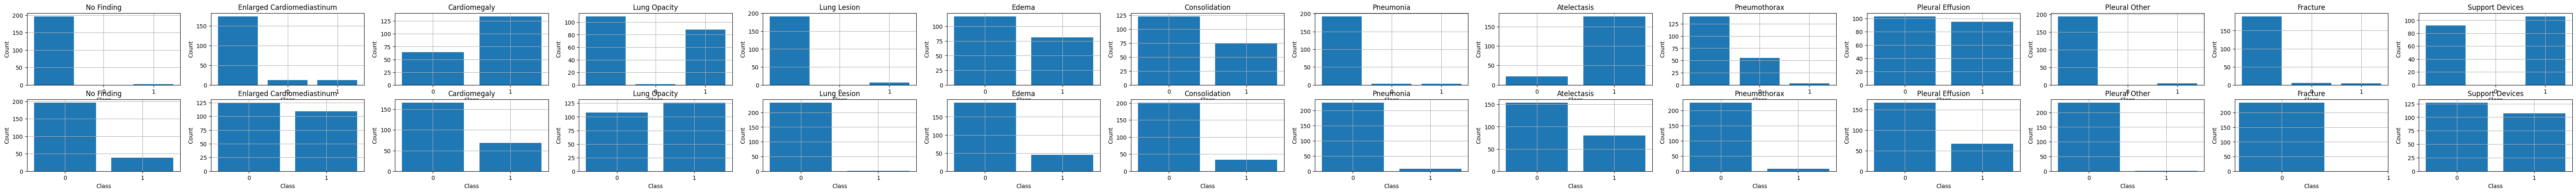

In [22]:
valid_samples_class_distribution = get_class_distribution(valid_samples)
valid_valid_class_distribution = get_class_distribution(val_og)

# Plot the class distribution
fig, ax = plt.subplots(2, len(valid_samples_class_distribution), figsize=(80, 5))

for i, (key, value) in enumerate(valid_samples_class_distribution.items()):
    ax[0, i].bar(value.index, value.values)
    ax[0, i].set_title(key)
    ax[0, i].set_xlabel("Class")
    ax[0, i].set_ylabel("Count")
    ax[0, i].set_xticks([0, 1])
    ax[0, i].set_xticklabels(["0", "1"])
    ax[0, i].grid()

for i, (key, value) in enumerate(valid_valid_class_distribution.items()):
    ax[1, i].bar(value.index, value.values)
    ax[1, i].set_title(key)
    ax[1, i].set_xlabel("Class")
    ax[1, i].set_ylabel("Count")
    ax[1, i].set_xticks([0, 1])
    ax[1, i].set_xticklabels(["0", "1"])
    ax[1, i].grid()


In [23]:
# Define the path 
output_dir = os.path.join(cwd_path.parent, 'data', 'only_valid_samples')

# Create the 'splitted' directory
os.makedirs(output_dir, exist_ok=True)

train_df = train_og
valid_df = val_og
test_df = valid_samples

# Save these subsets to CSVs
train_df.to_csv(os.path.join(output_dir, 'train.csv'), index=False)
valid_df.to_csv(os.path.join(output_dir, 'valid.csv'), index=False)
test_df.to_csv(os.path.join(output_dir, 'test.csv'), index=False)

train_df_ap = train_df[train_df['AP/PA'] == 'AP']
train_df_pa = train_df[train_df['AP/PA'] == 'PA']
valid_df_ap = valid_df[valid_df['AP/PA'] == 'AP']
valid_df_pa = valid_df[valid_df['AP/PA'] == 'PA']
test_df_ap = test_df[test_df['AP/PA'] == 'AP']
test_df_pa = test_df[test_df['AP/PA'] == 'PA']
train_df_fr = train_df[train_df['Frontal/Lateral'] == 'Frontal']
train_df_lat = train_df[train_df['Frontal/Lateral'] == 'Lateral']
valid_df_fr = valid_df[valid_df['Frontal/Lateral'] == 'Frontal']
valid_df_lat = valid_df[valid_df['Frontal/Lateral'] == 'Lateral']
test_df_fr = test_df[test_df['Frontal/Lateral'] == 'Frontal']
test_df_lat = test_df[test_df['Frontal/Lateral'] == 'Lateral']

train_df_ap.to_csv(os.path.join(output_dir, 'ap_train.csv'), index=False)
train_df_pa.to_csv(os.path.join(output_dir, 'pa_train.csv'), index=False)
valid_df_ap.to_csv(os.path.join(output_dir, 'ap_valid.csv'), index=False)
valid_df_pa.to_csv(os.path.join(output_dir, 'pa_valid.csv'), index=False)
test_df_ap.to_csv(os.path.join(output_dir, 'ap_test.csv'), index=False)
test_df_pa.to_csv(os.path.join(output_dir, 'pa_test.csv'), index=False)
train_df_fr.to_csv(os.path.join(output_dir, 'fr_train.csv'), index=False)
train_df_lat.to_csv(os.path.join(output_dir, 'lat_train.csv'), index=False)
valid_df_fr.to_csv(os.path.join(output_dir, 'fr_valid.csv'), index=False)
valid_df_lat.to_csv(os.path.join(output_dir, 'lat_valid.csv'), index=False)
test_df_fr.to_csv(os.path.join(output_dir, 'fr_test.csv'), index=False)
test_df_lat.to_csv(os.path.join(output_dir, 'lat_test.csv'), index=False)

print("Datasets have been saved.")
print(f"Train len: {len(train_df)}")
print(f"Test len: {len(test_df)}")
print(f"Valid len: {len(valid_df)}")

Datasets have been saved.
Train len: 223216
Test len: 198
Valid len: 234


# Original Dataset

This dataset is created using the original dataset and just maps the labels that are stings to numbers and splits the dataset into the different views.

In [5]:
# Define the columns to map NaN values to -1.0
columns_to_map = [
    "No Finding", "Enlarged Cardiomediastinum", "Cardiomegaly", 
    "Lung Opacity", "Lung Lesion", "Edema", "Consolidation", 
    "Pneumonia", "Atelectasis", "Pneumothorax", "Pleural Effusion", 
    "Pleural Other", "Fracture", "Support Devices"
]

cwd_path = Path.cwd()
train_path = cwd_path.parent.joinpath("data/original_data_unprocessed/train.csv")
val_path = cwd_path.parent.joinpath("data/original_data_unprocessed/valid.csv")
test_path = cwd_path.parent.joinpath("data/original_data_unprocessed//test.csv")
train_og = pd.read_csv(train_path)
print(f"Len train: {len(train_og)}")
val_og = pd.read_csv(val_path)
print(f"Len val: {len(val_og)}")
test_og = pd.DataFrame()

# Removing the single 'Unknown' value in 'Sex' 
train_og = train_og[train_og['Sex'] != 'Unknown']




Len train: 223414
Len val: 234


In [7]:



for data in [train_og, val_og]:
    # Use .loc[] to modify the original DataFrame
    data.loc[:, columns_to_map] = data[columns_to_map].fillna(-1.0)

    data['Sex_mapped'] = pd.factorize(data['Sex'])[0]
    data['Frontal/Lateral_mapped'] = pd.factorize(data['Frontal/Lateral'])[0]
    data['AP/PA_mapped'] = pd.factorize(data['AP/PA'])[0]

In [ ]:
# Define the path 
output_dir = os.path.join(cwd_path.parent, 'data', 'original_data')

# Create the 'splitted' directory
os.makedirs(output_dir, exist_ok=True)

# Cannot split the test set as ap/pa and frontal/lateral are not labeled
train_df = train_og
valid_df = val_og

# Save these subsets to CSVs
train_df.to_csv(os.path.join(output_dir, 'train.csv'), index=False)
valid_df.to_csv(os.path.join(output_dir, 'valid.csv'), index=False)

train_df_ap = train_df[train_df['AP/PA'] == 'AP']
train_df_pa = train_df[train_df['AP/PA'] == 'PA']
valid_df_ap = valid_df[valid_df['AP/PA'] == 'AP']
valid_df_pa = valid_df[valid_df['AP/PA'] == 'PA']
train_df_fr = train_df[train_df['Frontal/Lateral'] == 'Frontal']
train_df_lat = train_df[train_df['Frontal/Lateral'] == 'Lateral']
valid_df_fr = valid_df[valid_df['Frontal/Lateral'] == 'Frontal']
valid_df_lat = valid_df[valid_df['Frontal/Lateral'] == 'Lateral']

train_df_ap.to_csv(os.path.join(output_dir, 'ap_train.csv'), index=False)
train_df_pa.to_csv(os.path.join(output_dir, 'pa_train.csv'), index=False)
valid_df_ap.to_csv(os.path.join(output_dir, 'ap_valid.csv'), index=False)
valid_df_pa.to_csv(os.path.join(output_dir, 'pa_valid.csv'), index=False)
train_df_fr.to_csv(os.path.join(output_dir, 'fr_train.csv'), index=False)
train_df_lat.to_csv(os.path.join(output_dir, 'lat_train.csv'), index=False)
valid_df_fr.to_csv(os.path.join(output_dir, 'fr_valid.csv'), index=False)
valid_df_lat.to_csv(os.path.join(output_dir, 'lat_valid.csv'), index=False)

print("Datasets have been saved.")
print(f"Train len: {len(train_df)}")
print(f"Test len: {len(test_df)}")
print(f"Valid len: {len(valid_df)}")

Datasets have been saved.
Train len: 223413
Test len: 668
Valid len: 234
